In [1]:
import sys
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import config
import seaborn as sns
import SLM_utils as slm
plt.style.use("bmh")
import figure_utils
from scipy import stats 
from scipy import special
from numba import jit
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib import rc
rc('text', usetex=True)
import plot_cluster_utils as pcu
from matplotlib.lines import Line2D
from scipy.stats import gamma

SMALL_SIZE=15
MEDIUM_SIZE=20

rc('legend', fontsize=MEDIUM_SIZE)
rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
rc('ytick', labelsize=SMALL_SIZE)  
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821']

In [2]:
def afd_gamma(X_bar,beta):

    return gamma(beta,scale=X_bar/beta)

In [3]:
def sigma_2_xi(Ns,ns_i):
   # Ns = count_reads.sum()
   # ns_i = count_reads.loc[species]
    return(np.mean((ns_i*(ns_i - 1)/(Ns*(Ns-1)))) - np.mean(ns_i/Ns)**2)

In [4]:
@jit
def SLM(x_0,tau,sgm,K,N,nse,delta_t):
     
    X = [x_0]
    sqrt_delta_t = np.sqrt(delta_t)
    sqrt_sig_tau = np.sqrt(sgm/tau)
    
    for i in range(int(1/delta_t)*N):
        
        X_t = X[-1]
        
        X_t += (X_t/tau)*(1 - X_t/K)*delta_t + sqrt_sig_tau*X_t*nse[i]*sqrt_delta_t        
        
        X.append(X_t)    
    
    return(X)

In [15]:
species = "Bacteroides_uniformis_57318"
host = "an"
strain = 1
strain_total_freqs = pcu.get_strain_total_freqs(species,host)
strain_total_freqs[4] = strain_total_freqs[1] + strain_total_freqs[2]
strain = 2

/u/home/r/rwolff/diversity_ecology/scripts/plot_cluster_utils.py:28: RuntimeWarning: invalid value encountered in true_divide
  freqs[list(snp_map[key])[1]].append(np.array(list(snp_map[key])[2]/list(snp_map[key][3])))
/u/home/r/rwolff/diversity_ecology/scripts/plot_cluster_utils.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strain_df["Date_Diffs"][0] = 0.0


In [16]:
count_reads = pd.read_csv(f"{config.data_directory}species/count_reads.txt.bz2",sep="\t",index_col=0)
Ns = count_reads.sum()
ns_i = strain_total_freqs[strain]*Ns
times = np.cumsum(strain_total_freqs["Date_Diffs"])
times = list(times)
if 0 in strain_total_freqs[strain].values:
    dropind = np.argwhere((strain_total_freqs[strain] == 0).values)[0][0]
    del times[dropind]
    strain_total_freqs = strain_total_freqs.loc[strain_total_freqs[strain] != 0]
times = np.array(times)
N = times[-1]
count_reads = pd.read_csv(f"{config.data_directory}species/count_reads.txt.bz2",sep="\t",index_col=0)
Ns = count_reads.sum()
ns_i = strain_total_freqs[strain]*Ns
beta = strain_total_freqs[strain].mean()**2/sigma_2_xi(Ns,ns_i)
sigma = 2/(beta+1)
xbar = np.mean(strain_total_freqs[strain])
K = xbar/(1-sigma/2)
afd = afd_gamma(xbar,beta)

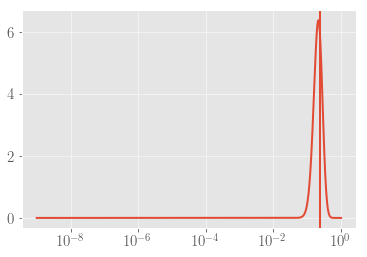

In [17]:
xrange = np.logspace(np.log10(1e-9),np.log10(1),int(1e3))
plt.plot(xrange,afd.pdf(xrange))
plt.semilogx()
plt.axvline(xbar)

In [18]:
x0 = afd.rvs(int(1e4))
ci = [afd.ppf(.05),afd.ppf(.95)]

In [19]:
delta_t = 1/2500
X_list = []
tau = 1

for i in range(int(1e3)):
    
    ns = np.random.normal(0, 1, int(N/delta_t))
    simvals = SLM(x0[i],tau,sigma,K,N,ns,delta_t)
    simvals = np.array(simvals[::int(1/delta_t)])
    simvals = simvals[times]
    X_list.append(simvals)
  

/u/local/apps/python/3.7.2/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/u/local/apps/python/3.7.2/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


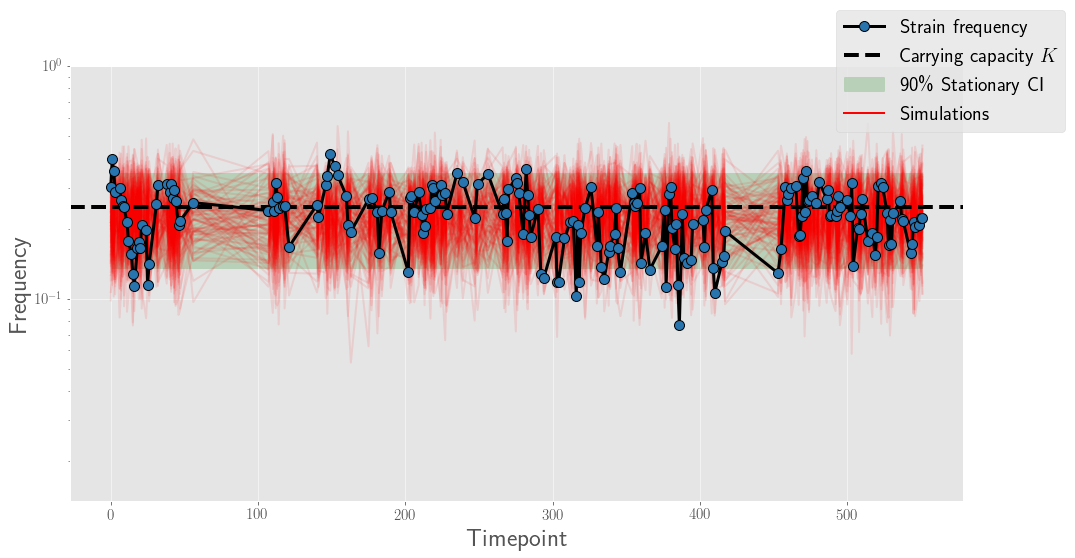

In [20]:
fig,ax = plt.subplots(figsize=(16,8))

for i in range(int(1e2)):
    
    ax.plot(times,X_list[i],alpha=.1,color="red",zorder=1,label=None)

ax.plot(times,strain_total_freqs[strain], 'o-',color="k",
        label="Strain frequency",markeredgecolor='k',markerfacecolor="#2774AE",zorder=2,lw=3,
        markersize=10)

ax.axhline(K,color="k",lw = 4,label=r"Carrying capacity $K$",linestyle="--",zorder=1)

ax.fill_between(times,ci[0],ci[1],alpha=.2,color="green",label="90\% Stationary CI",zorder=0)


handles, labels = plt.gca().get_legend_handles_labels()

line = Line2D([0], [0], label = 'Simulations',color='red')

handles.extend([line])

ax.set_ylim([.1*ci[0],1])

ax.set_yscale("log")

ax.set_ylabel("Frequency",size=25)

ax.set_xlabel("Timepoint",size=25)

fig.legend(handles=handles);

In [21]:
log_liks = []

for j in range(int(1e4)):
    
    sim = X_list[j]
    
    lklhds = afd.pdf(sim)
    log_liks.append(sum(np.log(lklhds)))

In [22]:
dat_ll = sum(np.log(afd.pdf(strain_total_freqs[strain])))

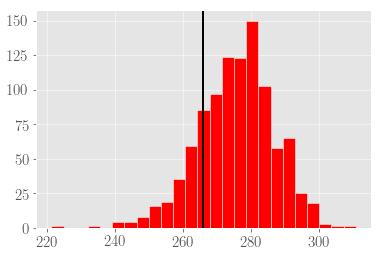

In [23]:
plt.hist(log_liks,color="r",ec="white",bins=25)
plt.axvline(dat_ll,zorder=1,color="k");

In [24]:
sum(1*(dat_ll > log_liks)/len(log_liks))

0.18200000000000013